In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"shehankavishka","key":"ee125e9915cd9a4e2e8c6a88c8e6c25c"}'}

In [5]:
!rm -r ~/.kaggle

rm: cannot remove '/root/.kaggle': No such file or directory


In [10]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [11]:
!mv ./kaggle.json ~/.kaggle/

In [12]:
!chmod 600 ~/.kaggle/kaggle.json

In [13]:
!kaggle datasets download -d harshwalia/birds-vs-drone-dataset

 90% 70.0M/78.1M [00:00<00:00, 110MB/s] 
100% 78.1M/78.1M [00:00<00:00, 91.2MB/s]


##Unzipping

In [14]:
import zipfile

In [15]:
zip_ref = zipfile.ZipFile('birds-vs-drone-dataset.zip', 'r')

In [16]:
zip_ref.extractall('/content')

In [17]:
zip_ref.close()

##Code

In [18]:
import os
for dirname, _, filenames in os.walk('/content/BirdVsDrone'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [20]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.9 MB/s eta 0:00:00


In [21]:
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from kerastuner.tuners import RandomSearch
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.preprocessing import image
from PIL import Image
import seaborn as sns
import cv2

<ipython-input-21-755b5d67b14f>:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [24]:
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from keras.preprocessing.image import ImageDataGenerator,  save_img

# Create an ImageDataGenerator with specified augmentations
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Directory to save the augmented images
augmented_dir = '/content/Augmented_data'

# Create directories to store augmented data
os.makedirs(os.path.join(augmented_dir, 'Birds'), exist_ok=True)
os.makedirs(os.path.join(augmented_dir, 'Drones'), exist_ok=True)

###Creting Birds Images

In [25]:
# Augment the "birds" class
for image_file in os.listdir('/content/BirdVsDrone/Birds'):
    img = load_img(os.path.join('/content/BirdVsDrone/Birds', image_file), target_size=(128, 128))
    img = img_to_array(img)
    img = img.reshape((1,) + img.shape)

    i = 0
    for batch in datagen.flow(img, batch_size=1):
        img = Image.fromarray(batch[0].astype('uint8'))
        img.save(os.path.join(augmented_dir, 'Birds', f'augmented_bird_{i}.jpg'))
        i += 1
        if i >= 400:  # Adjust the number of augmentations as needed
            break
    if i >= 400:  # Adjust the number of augmentations as needed
            break

###Creting Drone Images

In [26]:
# Augment the "drones" class
for image_file in os.listdir('/content/BirdVsDrone/Drones'):
    img = load_img(os.path.join('/content/BirdVsDrone/Drones', image_file), target_size=(128, 128))
    img = img_to_array(img)
    img = img.reshape((1,) + img.shape)

    i = 0
    for batch in datagen.flow(img, batch_size=1):
        img = Image.fromarray(batch[0].astype('uint8'))
        img.save(os.path.join(augmented_dir, 'Drones', f'augmented_drone_{i}.jpg'))
        i += 1
        if i >= 400:  # Adjust the number of augmentations as needed
            break
    if i >= 400:  # Adjust the number of augmentations as needed
            break

###Copying Birds Images

In [27]:
source_dir = '/content/BirdVsDrone/Birds'
destination_dir = '/content/Augmented_data/Birds'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# List the files in the source directory
file_list = os.listdir(source_dir)

num_images_to_copy = 400

for i, file_name in enumerate(file_list):
    if i >= num_images_to_copy:
        break
    source_file_path = os.path.join(source_dir, file_name)
    destination_file_path = os.path.join(destination_dir, file_name)

    shutil.copy(source_file_path, destination_file_path)
    # print(f'Copied: {file_name}')

print(f'Copied {num_images_to_copy} images from {source_dir} to {destination_dir}')

Copied 400 images from /content/BirdVsDrone/Birds to /content/Augmented_data/Birds


###Copying Drone Images

In [28]:
source_dir = '/content/BirdVsDrone/Drones'
destination_dir = '/content/Augmented_data/Drones'

os.makedirs(destination_dir, exist_ok=True)

file_list = os.listdir(source_dir)

num_images_to_copy = 400

for i, file_name in enumerate(file_list):
    if i >= num_images_to_copy:
        break
    source_file_path = os.path.join(source_dir, file_name)
    destination_file_path = os.path.join(destination_dir, file_name)

    shutil.copy(source_file_path, destination_file_path)
    # print(f'Copied: {file_name}')

print(f'Copied {num_images_to_copy} images from {source_dir} to {destination_dir}')

Copied 400 images from /content/BirdVsDrone/Drones to /content/Augmented_data/Drones


####Copying Data from the Source to destination

In [29]:
source_directory = "/content/Augmented_data"

destination_directory = "/content/Split_data"

In [30]:
class_labels = ["Birds", "Drones"]

for label in class_labels:
    os.makedirs(os.path.join(destination_directory, 'train', label), exist_ok=True)
#     os.makedirs(os.path.join(destination_directory, 'validation', label), exist_ok=True)
    os.makedirs(os.path.join(destination_directory, 'test', label), exist_ok=True)

# Split the data into training, validation, and testing sets
train_size = 0.8 # 80% for training
# validation_size = 0.3  # 20% for validation
test_size = 0.2  # 20% for testing

In [31]:
for label in class_labels:
    source_label_dir = os.path.join(source_directory, label)
    train_label_dir = os.path.join(destination_directory, 'train', label)
    test_label_dir = os.path.join(destination_directory, 'test', label)

    files = os.listdir(source_label_dir)

    train_files, test_files = train_test_split(files, test_size=0.2 , random_state=42)

    for file in train_files:
        src = os.path.join(source_label_dir, file)
        dst = os.path.join(train_label_dir, file)
        shutil.copy(src, dst)

    for file in test_files:
        src = os.path.join(source_label_dir, file)
        dst = os.path.join(test_label_dir, file)
        shutil.copy(src, dst)

In [32]:
# Define the preprocessing function
def preprocess_image(image, label):
    image = tf.image.resize(image, (28, 28))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label

In [33]:
# Load and preprocess the training and testing datasets
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/Split_data/train',
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(28, 28)
)

test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/Split_data/test',
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(28, 28)
)

Found 1278 files belonging to 2 classes.
Found 320 files belonging to 2 classes.


In [34]:
# Apply the preprocessing function to the datasets
train_ds = train_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)

In [35]:
# Split the training dataset into training and validation sets
train_size = int(0.9 * len(train_ds))
train_images = train_ds.take(train_size)
val_images = train_ds.skip(train_size)

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(48, (5, 5), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 128)       9728      
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 48)        153648    
                                                                 
 flatten (Flatten)           (None, 19200)             0         
                                                                 
 dense (Dense)               (None, 64)                1228864   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1392305 (5.31 MB)
Trainable params: 1392305 (5.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    batch_size=32,
    verbose=2
)

Epoch 1/10
36/36 - 19s - loss: 0.5932 - accuracy: 0.7118 - val_loss: 0.4375 - val_accuracy: 0.8254 - 19s/epoch - 534ms/step
Epoch 2/10
36/36 - 19s - loss: 0.6081 - accuracy: 0.7135 - val_loss: 0.4975 - val_accuracy: 0.7302 - 19s/epoch - 521ms/step
Epoch 3/10
36/36 - 19s - loss: 0.4836 - accuracy: 0.7509 - val_loss: 0.4868 - val_accuracy: 0.7381 - 19s/epoch - 541ms/step
Epoch 4/10
36/36 - 19s - loss: 0.4563 - accuracy: 0.7630 - val_loss: 0.4199 - val_accuracy: 0.8413 - 19s/epoch - 539ms/step
Epoch 5/10
36/36 - 19s - loss: 0.4264 - accuracy: 0.7995 - val_loss: 0.3936 - val_accuracy: 0.7619 - 19s/epoch - 531ms/step
Epoch 6/10
36/36 - 19s - loss: 0.4049 - accuracy: 0.8177 - val_loss: 0.4514 - val_accuracy: 0.8095 - 19s/epoch - 522ms/step
Epoch 7/10
36/36 - 19s - loss: 0.3597 - accuracy: 0.8429 - val_loss: 0.3665 - val_accuracy: 0.8175 - 19s/epoch - 531ms/step
Epoch 8/10
36/36 - 19s - loss: 0.3267 - accuracy: 0.8516 - val_loss: 0.3442 - val_accuracy: 0.8175 - 19s/epoch - 537ms/step
Epoch 9/

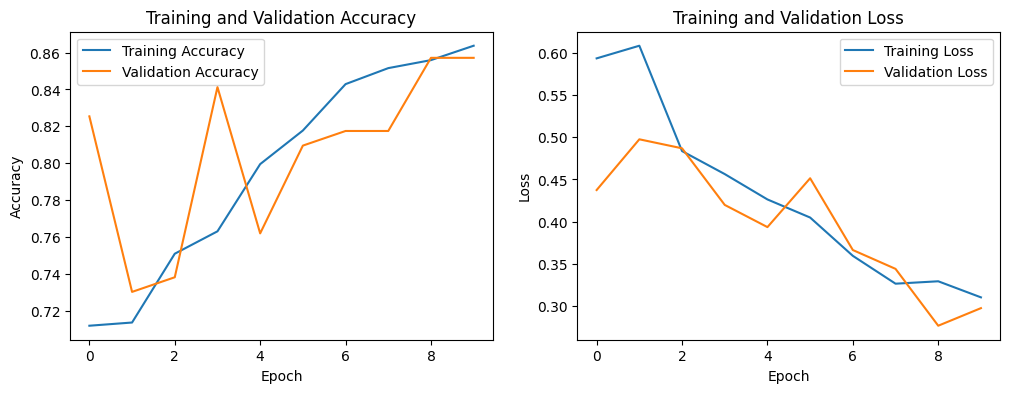

In [40]:
# Plot training and validation accuracies
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation losses
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plt.show()
plt.savefig('training_plots_10.png')
plt.show()

In [41]:
# Calculate training accuracy and loss
train_loss, train_accuracy = model.evaluate(train_ds)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

# Calculate test accuracy and loss
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

40/40 [==============================] - 6s 145ms/step - loss: 0.2833 - accuracy: 0.8764
Training Loss: 0.2833
Training Accuracy: 0.8764
10/10 [==============================] - 2s 82ms/step - loss: 0.3009 - accuracy: 0.8875
Test Loss: 0.3009
Test Accuracy: 0.8875


In [42]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
# Load your trained model
model = tf.keras.models.load_model('model.h5')

Found 320 files belonging to 2 classes.
1/1 [==============================] - 0s 90ms/step
Classification Report:
               precision    recall  f1-score   support

      Drones       0.72      0.96      0.82       160
       Birds       0.94      0.62      0.75       160

    accuracy                           0.79       320
   macro avg       0.83      0.79      0.79       320
weighted avg       0.83      0.79      0.79       320



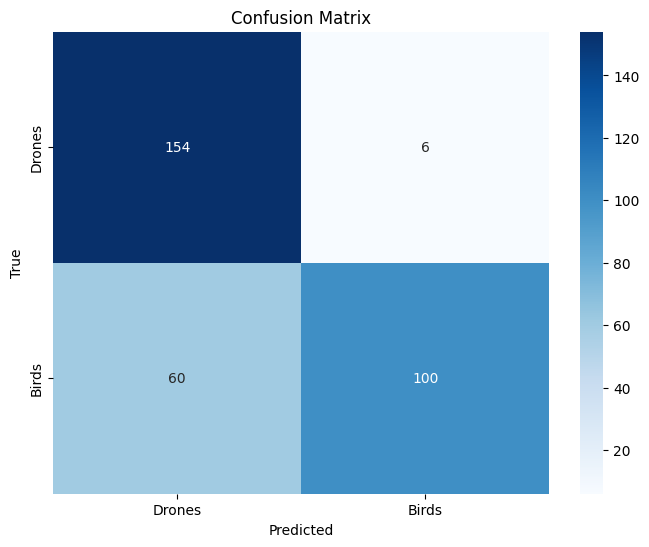

In [44]:
# Load and preprocess the test dataset
test_dataset_path = '/content/Split_data/test'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dataset_path,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(28, 28)
)

# Define the class names
class_names = ['Drones', 'Birds']  # Adjust based on your classes

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# Iterate through the test dataset to make predictions
for images, labels in test_ds:
    true_labels.extend(labels.numpy())
    predicted_labels = model.predict(images)
    predictions.extend((predicted_labels > 0.5).astype(int).flatten())

# Generate a classification report
report = classification_report(true_labels, predictions, target_names=class_names)
print("Classification Report:\n", report)

# Generate a confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
# Save the confusion matrix plot to a file
plt.savefig('confusion_matrix_10.png')

plt.show()

####Make Prediction


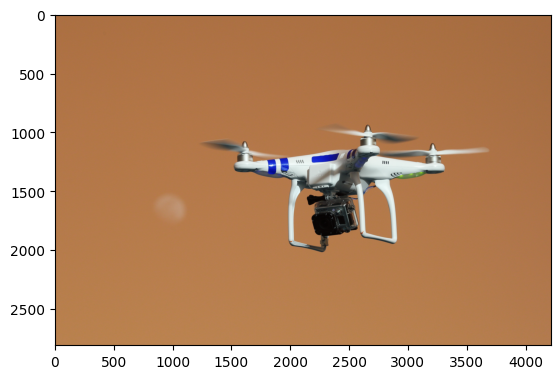

In [67]:
# Load and resize the image
image_path = "/content/Drone_with_GoPro_digital_camera_mounted_underneath_-_22_April_2013.jpg"
test_img = cv2.imread(image_path)
plt.imshow(test_img)

In [68]:
image = cv2.imread(image_path)
image = tf.image.resize(image, (28, 28))
scaled_image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
scaled_image = np.expand_dims(scaled_image, axis=0)
pred = model.predict(scaled_image)
pred

1/1 [==============================] - 0s 25ms/step


array([[0.01782028]], dtype=float32)

In [70]:
# Get the predicted class index
predicted_class_index = int(pred >= 0.5)

# Get the predicted class label using the index
predicted_class_label = class_names[predicted_class_index]

# Print the predicted class label
print(predicted_class_label)

Drones


<ipython-input-70-8d84c264ff8a>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class_index = int(pred >= 0.5)


In [71]:
!jupyter nbconvert --to html /content/model.ipynb


[NbConvertApp] Converting notebook /content/model.ipynb to html
[NbConvertApp] Writing 989855 bytes to /content/model.html
